**Let's start with the imports needed for this project**

In [ ]:
import numpy as np
import matplotlib as plt
%matplotlib inline
import time
import csv

In this code, the `convert` function is used to convert MNIST data into a CSV format. It takes four inputs: `imgf` (image file), `labelf` (label file), `outf` (output file), and `n` (number of images).

The image and label files are opened in binary mode, and the output file in write mode. The function skips the first 16 bytes of the image file and 8 bytes of the label file, as they contain metadata.

For each of the `n` images, the function reads one byte from the label file (the digit label) and 784 bytes from the image file (28x28 pixel values), storing them in a list. This data is collected in the `images` list.

Once all images are processed, the function writes each image's label and pixel data to the CSV file as a comma-separated string. Finally, all files are closed. This allows the MNIST dataset to be saved in a readable CSV format for further use.

In [ ]:
def convert(imgf, labelf, outf, n):
    f = open(imgf, "rb")
    o = open(outf, "w")
    l = open(labelf, "rb")

    f.read(16)
    l.read(8)
    images = []

    for i in range(n):
        image = [ord(l.read(1))]
        for j in range(28*28):
            image.append(ord(f.read(1)))
        images.append(image)

    for image in images:
        o.write(",".join(str(pix) for pix in image)+"\n")
    f.close()
    o.close()
    l.close()

In [ ]:
convert("/content/data/train-images.idx3-ubyte", "/content/data/train-labels.idx1-ubyte",
        "/content/data/train.csv", 60000)
convert("/content/data/t10k-images.idx3-ubyte", "/content/data/t10k-labels.idx1-ubyte",
        "/content/data/test.csv", 10000)

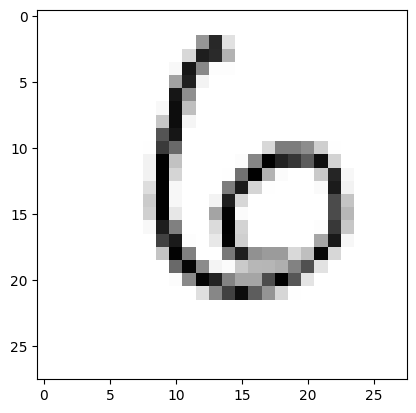

In [ ]:
test_file = open("/content/data/test.csv", "r")
test_list = test_file.readlines()
test_file.close()


all_values = test_list[100].split(',')
image_array = np.asfarray(all_values[1:]).reshape((28,28))
plt.pyplot.imshow(image_array, cmap='Greys', interpolation='None')

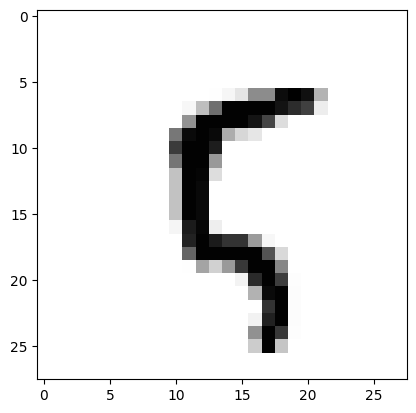

In [ ]:
train_file = open("/content/data/train.csv", "r")
train_list = train_file.readlines()
train_file.close()

values = train_list[100].split(",")
image_array = np.asfarray(values[1:]).reshape((28,28))
plt.pyplot.imshow(image_array, cmap="Greys", interpolation ="None")


In [ ]:
print(len(test_list),len(train_list))

10000 60000


# **Class Definition**
The DNN class implements a deep neural network for classification tasks. It takes three parameters:

sizes : defines the number of neurons in each layer.
epochs: the number of training iterations.
lr: the learning rate for weight updates.
Initialization
In the __init__ method, random weights are initialized for each layer using Xavier initialization, based on the sizes provided.

# **Activation Functions**
Sigmoid: Computes the sigmoid activation and its derivative.
Softmax: Computes the softmax activation and its derivative for multi-class classification.
Forward Pass
The forward_pass method calculates the weighted sums and activations for each layer, returning the output from the final softmax layer.

# **Backward Pass**
The backward_pass method computes gradients of the loss with respect to each layer’s weights, using the chain rule and derivatives, and returns the necessary weight updates.

# **Weight Update**
The update_weights method updates the weights using the computed changes and the learning rate.

# **Accuracy Calculation**
The compute_accuracy method evaluates the model on the test dataset, returning the overall accuracy by comparing predicted outputs to true labels.

# **Training the Model**
The train method iterates over the epochs, performing forward and backward passes for each training example, updating weights, and printing the training accuracy after each epoch.

## I**nstantiation**
Finally, an instance of the DNN class is created with specified parameters, and the training process is initiated with the provided datasets.

In [ ]:
class DNN:

  def __init__(self, sizes, epochs, lr ):
    self.sizes = sizes
    self.epochs = epochs
    self.lr = lr

    input_layer = self.sizes[0]
    hidden_1 = self.sizes[1]
    hidden_2 = self.sizes[2]
    output_layer = self.sizes[3]

    self.params = {
        "W1":np.random.rand(hidden_1, input_layer) * np.sqrt(1./hidden_1),
        "W2":np.random.rand(hidden_2, hidden_1) * np.sqrt(1./hidden_2),
        "W3":np.random.rand(output_layer, hidden_2)*np.sqrt(1./output_layer)
    }

  def sigmoid(self, x ,derivative = False):
    if derivative:
      return(np.exp(-x))/((np.exp(-x)+1)**2)
    return 1/(1+np.exp(-x))

  def softmax(self, x, derivative= False):
    exps = np.exp(x-x.max())
    if derivative:
      return exps/ np.sum(exps, axis =0) * (1- exps/np.sum(exps,axis =0))
    return exps/np.sum(exps, axis =0)

  def forward_pass(self, X_train):
    params = self.params

    params["A0"] = X_train

    params["Z1"] = np.dot(params["W1"],params["A0"])
    params["A1"] = self.sigmoid(params["Z1"])

    params["Z2"] = np.dot(params["W2"], params["A1"])
    params["A2"] = self.sigmoid(params["Z2"])

    params["Z3"] = np.dot(params["W3"],params["A2"])
    params["A3"] = self.softmax(params["Z3"])

    return params["A3"]

  def backward_pass(self, y_train, output):
    params = self.params

    change_w = {}

    error = 2 * (output - y_train) / output.shape[0] * self.softmax(params["Z3"], derivative = True)
    change_w["W3"] = np.outer(error, params["A2"])

    error = np.dot(params["W3"].T ,error) * self.sigmoid(params["Z2"], derivative = True)
    change_w["W2"] = np.outer(error,params["A1"])

    error = np.dot(params["W2"].T ,error) * self.sigmoid(params["Z1"], derivative = True)
    change_w["W1"] = np.outer(error,params["A0"])

    return change_w

  def update_weights(self,change_w):
    for key,val in change_w.items():
      self.params[key] -= self.lr * val
  def compute_accuracy(self, test_data,output_nodes):
    predictions = []
    for x in test_data:
      values = x.split(",")
      inputs = (np.asfarray(values[1:])/255.0 * 0.99) + 0.01
      targets = np.zeros(10) + 0.01
      targets[int(values[0])] = 0.99
      output = self.forward_pass(inputs)
      pred = np.argmax(output)
      predictions.append(pred == np.argmax(targets))
    return np.mean(predictions)


  def train(self,train_list, test_list):
    for i in range(self.epochs):
      start_time = time.time()
      for x in train_list:
        values = x.split(",")
        inputs = (np.asfarray(values[1:])/255.0 * 0.99 )+ 0.01
        targets = np.zeros(10) + 0.01
        targets[int(values[0])] = 0.99
        output = self.forward_pass(inputs)
        change_w = self.backward_pass(targets,output)
        self.update_weights(change_w)
      accuracy = self.compute_accuracy(test_list,output)
      print("Epoch: {0} Time Spent: {1:.02f}s, Accuracy: {2:.2f}%".format(i+1, time.time()-start_time, accuracy*100) )


dnn = DNN(sizes=[784, 128, 64, 10 ], epochs = 10, lr = 0.001)
dnn.train(train_list, test_list)






Epoch: 1 Time Spent: 98.19s, Accuracy: 10.28%
Epoch: 2 Time Spent: 94.87s, Accuracy: 11.26%
Epoch: 3 Time Spent: 99.21s, Accuracy: 11.27%
Epoch: 4 Time Spent: 98.65s, Accuracy: 11.27%
Epoch: 5 Time Spent: 99.22s, Accuracy: 11.28%
Epoch: 6 Time Spent: 98.44s, Accuracy: 11.28%
Epoch: 7 Time Spent: 99.45s, Accuracy: 11.28%
Epoch: 8 Time Spent: 100.03s, Accuracy: 11.28%
Epoch: 9 Time Spent: 98.38s, Accuracy: 11.28%
Epoch: 10 Time Spent: 95.31s, Accuracy: 11.29%
